In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import csv
import ROOT
import pickle
from scipy import interpolate

import tb2024a as tb

dfmain={} # top level event data structure, containg sub-structure
#  (per event)   df_ev
#  (event info)  dfinfo, 
#  (simhit)  dfCshit2D, dfCshit3D, dfSshit2D, dfSshit3D  [chID, val] - pulse train from G4
#  (digihit) dfCdhit2D, dfCdhit3D, dfSdhit2D, dfSdhit3D  [chID, val] - simulated waveform
#  (rechit)  dfCrhit2D, dfCrhit3D, dfSrhit2D, dfSrhit3D  [chID, val] - reconstructed pulse train

#  (per event)   event 
#  (simhit) 　simhit2dC, simhit2dS, simhit3dC, simhit3dS   - pulse train from G4
#  (waaveform) waveform2dC, waveform2dS, waveform3dC, waveform3dS - convoluted waveform
#  (rechit)  rechit2dC, rechit2dS, rechit3dC, rechit3dS   - reconstructed pulse train
#
#  event={eventID, }
#  simhit   = {chID, vals}
#  waveform = {chID, vals}
#  rechit   = {chID, vals}
#  chID=ix*1000000+iy*1000+it   (it:  50 ps or 200 ps slice)
#  chID=ix*1000000+iy*1000+iz   (iz:  2cm slicd? for dfCrhit3Dz in case of z-slice in MC)

ok=tb.test()  #  test to make sure the library tb2024 is loaded.
if ok>0:
    print("The library tb2024 is loaded sucessfully,  return code=",ok)

#
h1d={}   # for root histograming
h2d={}   # for root histograming (inteded for 2d histograms, but h1d may be used for 2d as well

maxEvents=10    # number of events to process
calibSS=1.0    # edep2GeV factor for scintillation signal (actual value from input nutple file)
calibCC=1.0    # ph2GeV factor for Cherenkov signal  (actual value from input nutple file)

fout=ROOT.TFile.Open("hgdream3dAnalysis.root","recreate")

Welcome to JupyROOT 6.30/04
print out in tb2024/test
The library tb2024 is loaded sucessfully,  return code= 1


In [2]:
class ntupleList:
    def __init__(self):
        self.files={}
        self.trees={}
        self.keys=[]
        self.indir="/Users/kunori/skdir/CaloX/dream2.05pre03/sim/build02/"
        self.files["pi+100"]= ROOT.TFile.Open(self.indir+"mc_testjob_run002_001_Test_100evt_pi+_100.0_100.0.root")
        self.files["e+100"]= ROOT.TFile.Open(self.indir+"mc_testjob_run001_001_Test_100evt_e+_100.0_100.0.root")
        print(type(self.files))

        for key in self.files.keys():
            # print("key=",key)
            self.keys.append(key)
            self.trees[key]=self.files[key].Get("tree")
            
        print("class ntupleList- keys")
        print(self.keys)
        
    
    def getKeys(self):
        return self.keys
    
    def getList(self):
        return self.files
    
    def getTrees(self):
        return self.trees
        

(def getPulseShapeFromPkl)  fname=  pulsedata_1033.pkl
Using run:  1033
number of pulses (events):  943
chlist: [1, 3, 6, 9]
(def plotPulseShape) type(df <class 'dict'>
run:  1033
number of events:  943
chlist: [1, 3, 6, 9]
ch  1    1mm_fast
ch  3    3mm_fast
ch  6    6mm_fast
ch  9    1mm_fast2


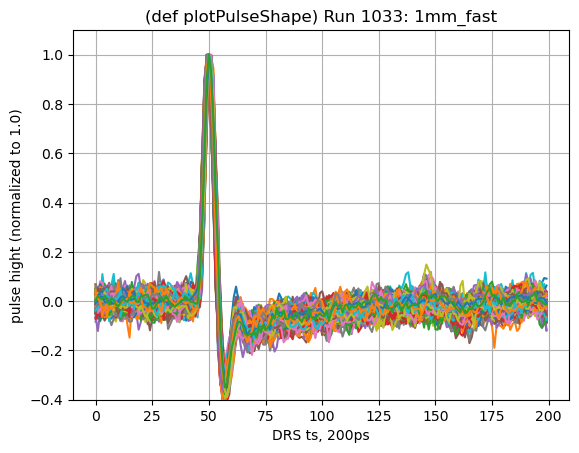

(def get_splwave) creating a set of single photon pulse shape with 
spline fits to measured pulse shapes in the pulse shape library from pkl file.
Example of a pulse shape from spline fit.
40 ns wide,  5 ps step.  Total 8000 steps.
ysum= 1.7092044683077177   ysum2= 237.2925828295545  ysum3  -235.58337836124682   ysum2+ysum3 1.7092044683076892


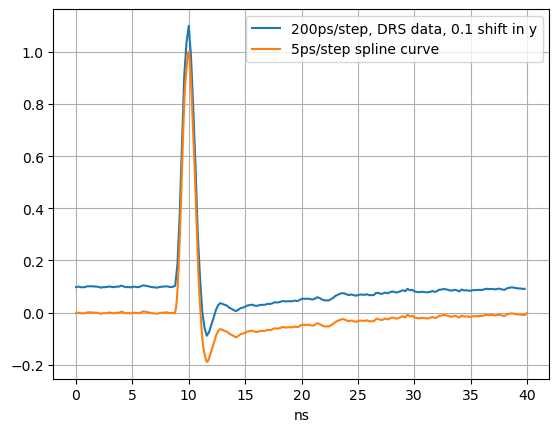

The number of spline wave is  943 . 


In [3]:
#  load pulse shapes from pkl file 
#  pkl files are originally in skmac20:/Users/kunori/skdir/CaloX/dream1.02/plotter
#  and copied to current directory.

rng = np.random.default_rng()

dfPulseShape=tb.getPulseShapeFromPkl("pulsedata_1033.pkl")
#
tb.plotPulseShape(dfPulseShape)
#
n_splwave,splwave,timeslices=tb.get_splwave(dfPulseShape)
print("The number of spline wave is ",n_splwave,". ")


In [4]:
def processDataset(dataset,trees):
    global maxEvents
    global rng
    print("  ")
    print("= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =")
    print("= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =")
    print("(def processDataset)  ",dataset)
    #
    t0=trees[dataset]
    print(t0)
    #
    dfmain={}
    printFlag=0
    for it,t in enumerate(t0):
        if (it+1)>maxEvents:    
            break
        if it<2:
            printFlag=1
            
        df={}
        tb.getG4data(dataset,t,df)
        #  simulate DRS waveform using tthe pulse shape library.
        df["drsCC"]=tb.makeDRSwave_v01(df,n_splwave,splwave,rng)
        
        if printFlag>0:
            print("(def processDataset) df.keys():",df.keys())
            # print("df[drsCC].keys():",df["drsCC"].keys())

        a=(np.argsort(df["g4hit2dCC"]["val"]))[::-1]
        v0=df["g4hit2dCC"]["val"][a[0]]
        v1=df["g4hit2dCC"]["val"][a[1]]
        print("v0 ",v0,"  v1 ",v1)
        
        channelList=[df["g4hit2dCC"]["id"][a[0]], df["g4hit2dCC"]["id"][a[1]]]
        tb.plotPulseTrain_v01(df,channelList)
        
        # put event data in dfmain for pickle output...
        dfmain[it]=df

    pklname="pkl_"+dataset+".pkl"
    with open(pklname,"wb") as file:
        pickle.dump(dfmain,file)
    
    return

<class 'dict'>
class ntupleList- keys
['pi+100', 'e+100']
start processing key number  0 / 6    pi+100
  
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
(def processDataset)   pi+100
Name: tree Title: CaloX Tree
(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  271.0   v1  192.0
(def plotPulseTrain_v01) ch 140101


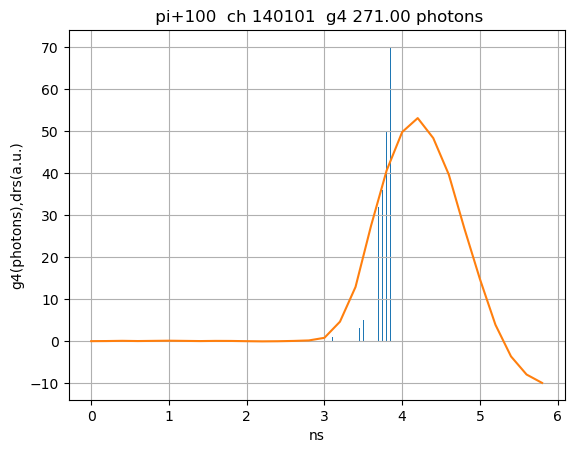

(def plotPulseTrain_v01) ch 180060


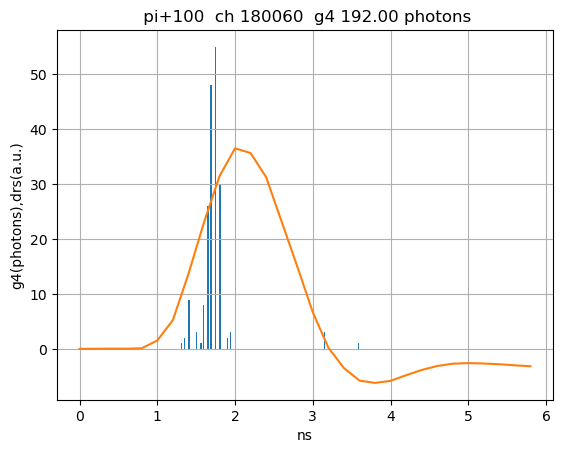

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  158.0   v1  152.0
(def plotPulseTrain_v01) ch 140101


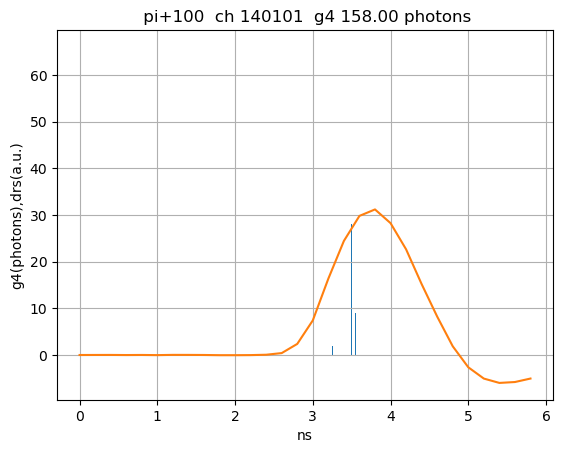

(def plotPulseTrain_v01) ch 140094


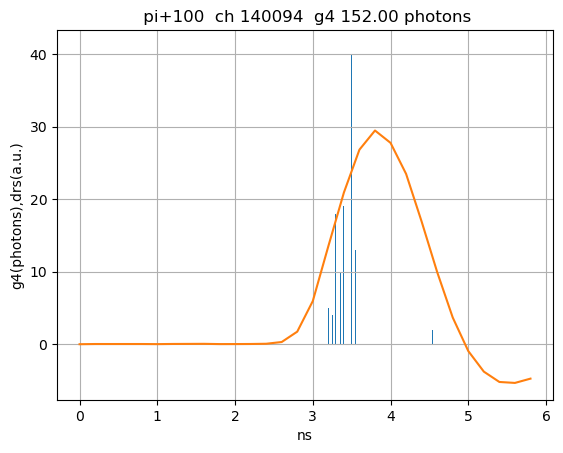

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  337.0   v1  264.0
(def plotPulseTrain_v01) ch 160083


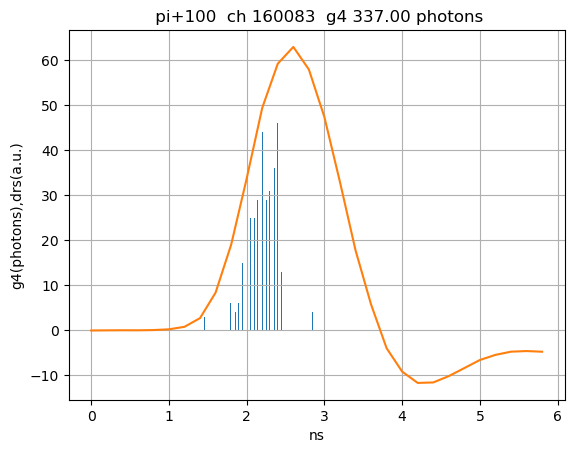

(def plotPulseTrain_v01) ch 160084


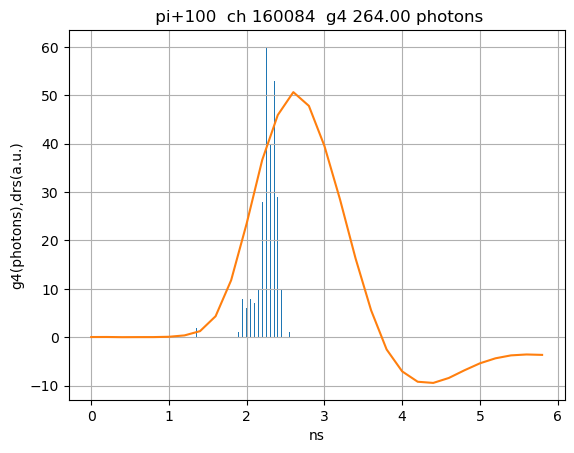

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  140.0   v1  96.0
(def plotPulseTrain_v01) ch 140103


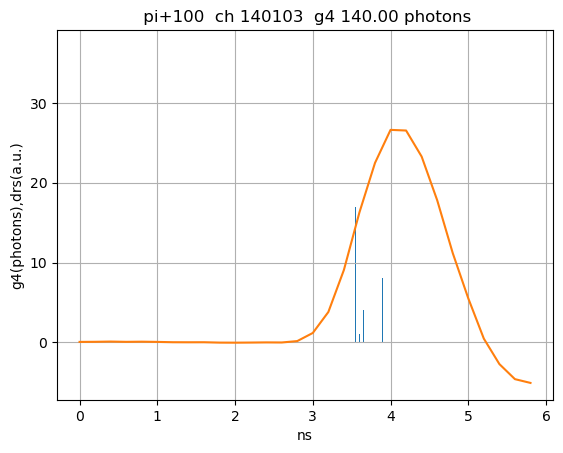

(def plotPulseTrain_v01) ch 140104


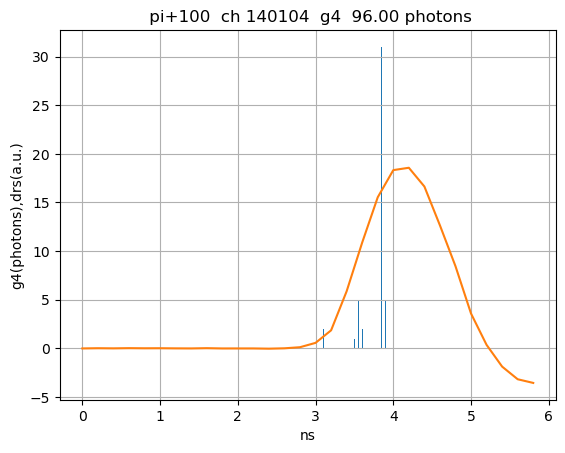

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  315.0   v1  216.0
(def plotPulseTrain_v01) ch 170070


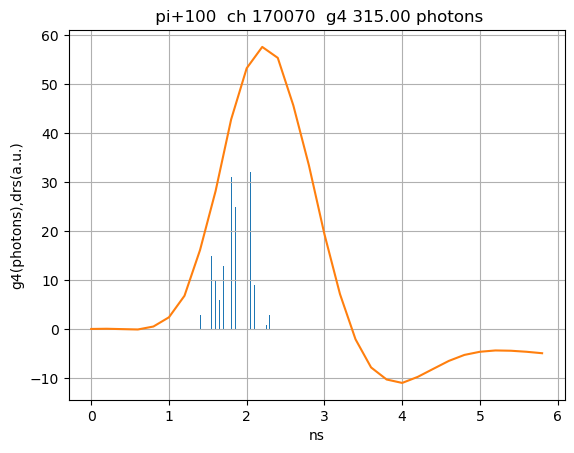

(def plotPulseTrain_v01) ch 160070


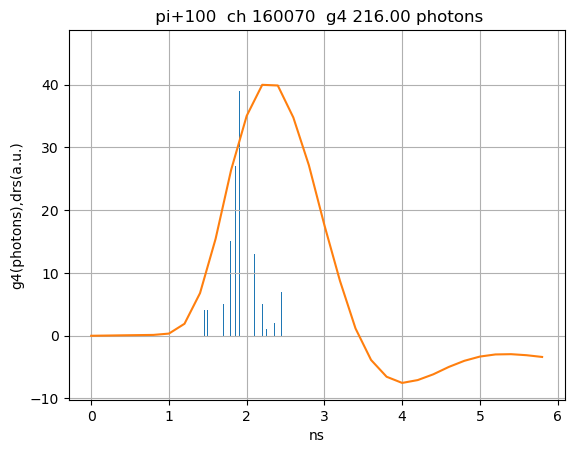

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  476.0   v1  475.0
(def plotPulseTrain_v01) ch 160091


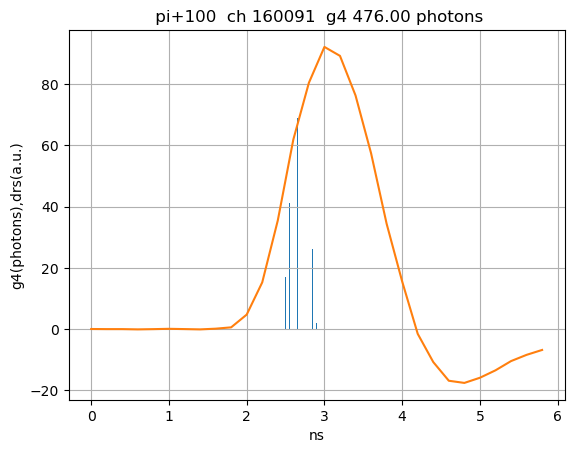

(def plotPulseTrain_v01) ch 160092


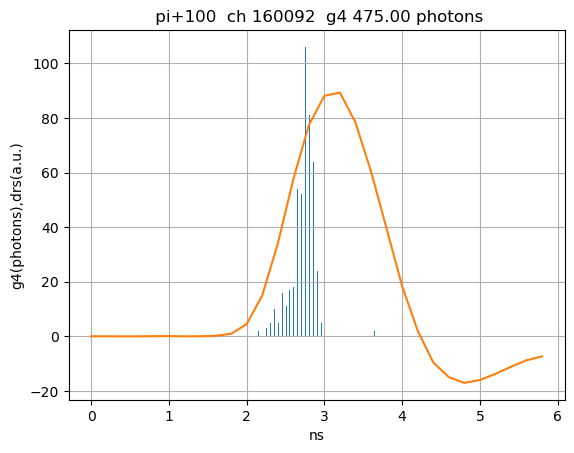

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  196.0   v1  131.0
(def plotPulseTrain_v01) ch 140102


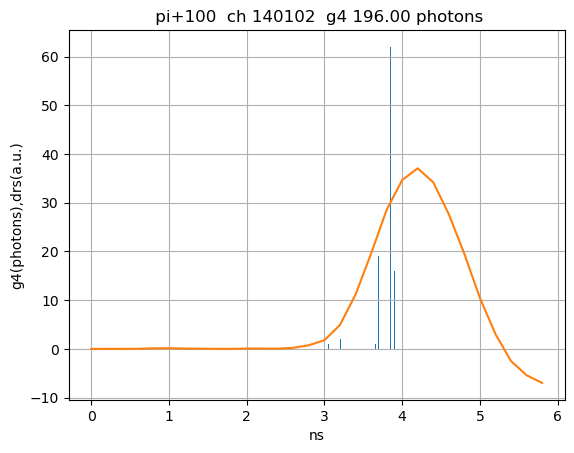

(def plotPulseTrain_v01) ch 140101


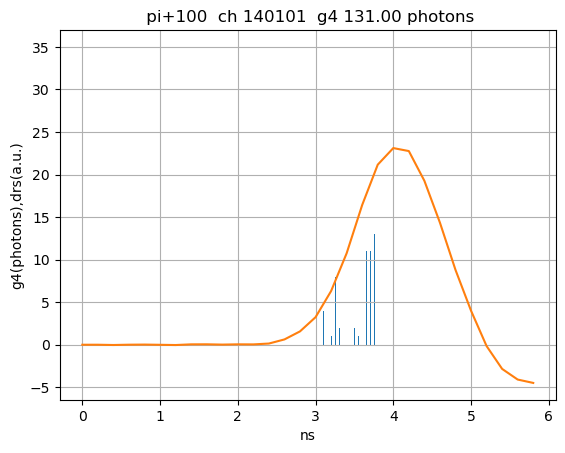

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  426.0   v1  316.0
(def plotPulseTrain_v01) ch 150094


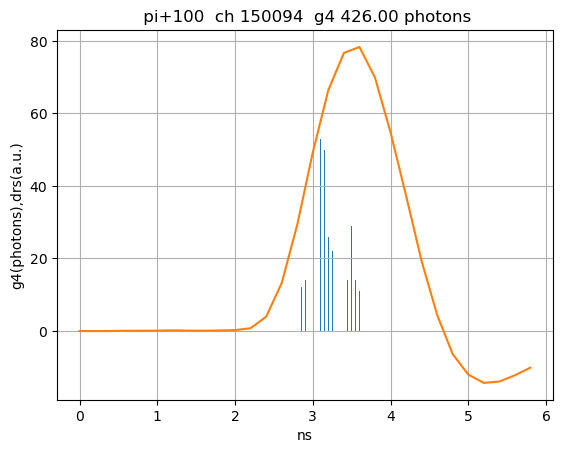

(def plotPulseTrain_v01) ch 150093


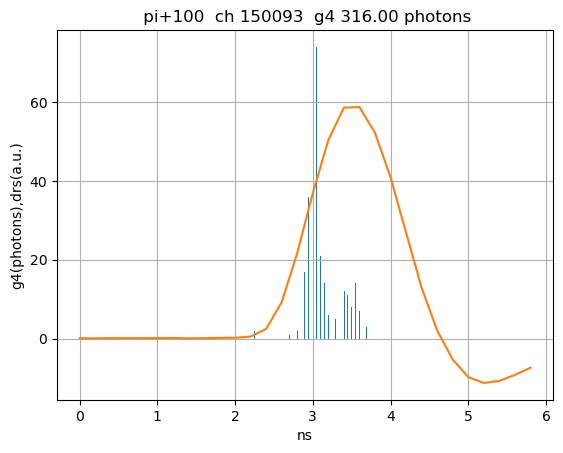

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  198.0   v1  194.0
(def plotPulseTrain_v01) ch 140102


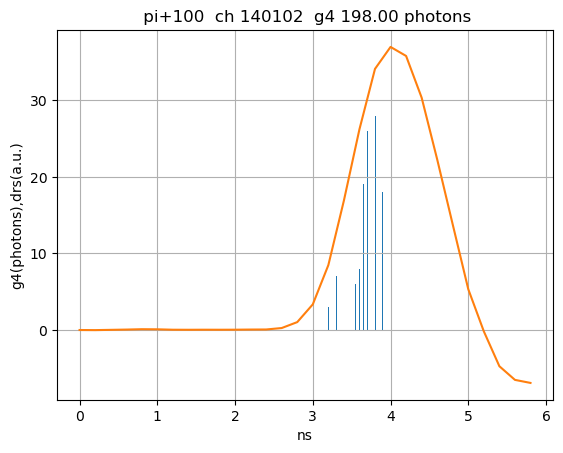

(def plotPulseTrain_v01) ch 140103


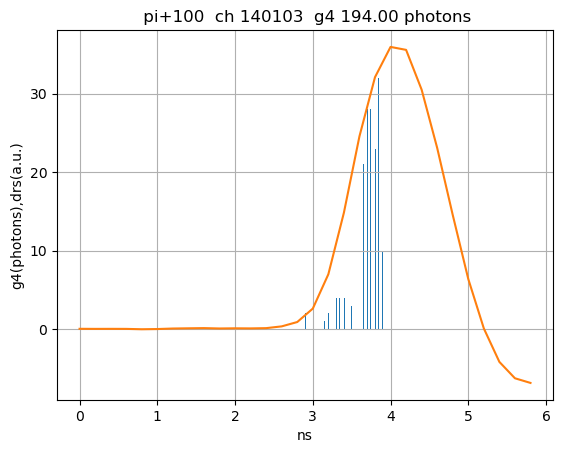

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  610.0   v1  342.0
(def plotPulseTrain_v01) ch 140101


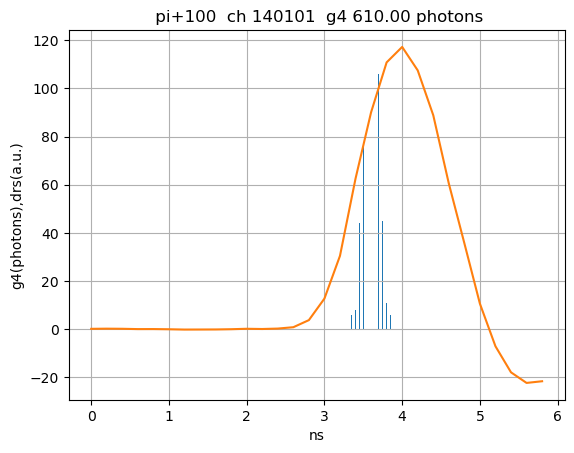

(def plotPulseTrain_v01) ch 140094


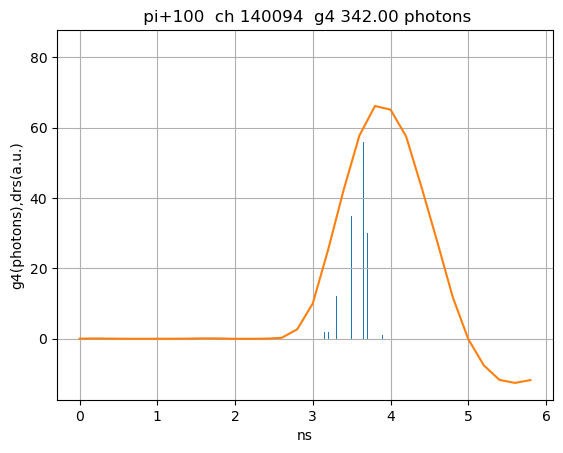

start processing key number  1 / 5    e+100
  
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
= = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
(def processDataset)   e+100
Name: tree Title: CaloX Tree
(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  1102.0   v1  602.0
(def plotPulseTrain_v01) ch 140103


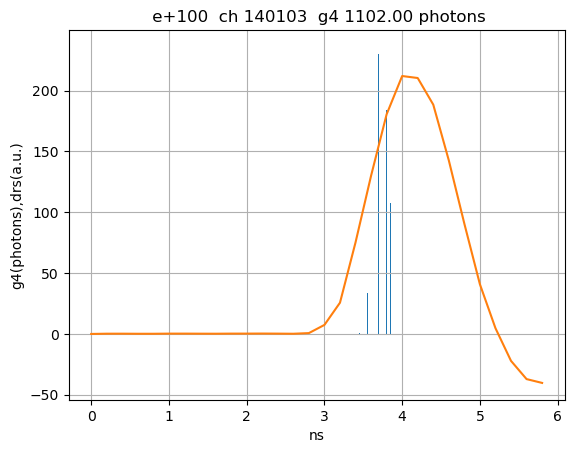

(def plotPulseTrain_v01) ch 140102


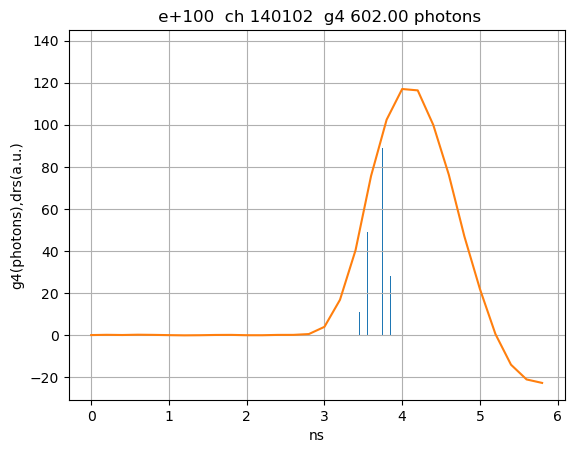

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  1174.0   v1  588.0
(def plotPulseTrain_v01) ch 140102


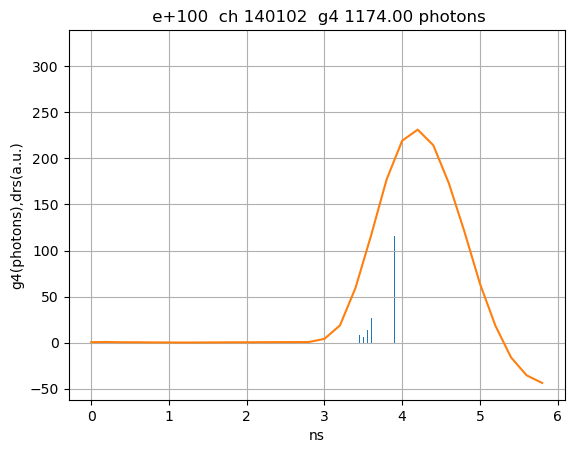

(def plotPulseTrain_v01) ch 140101


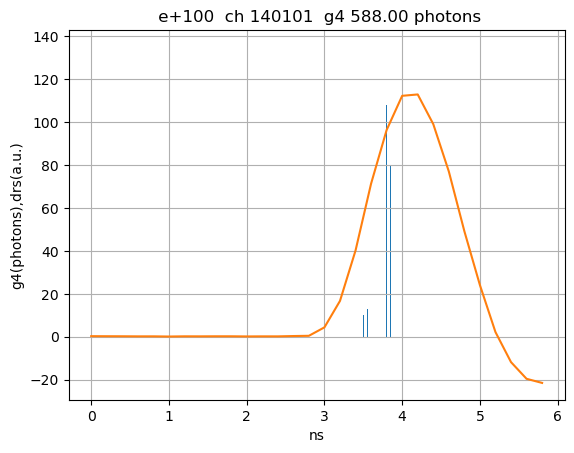

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  848.0   v1  681.0
(def plotPulseTrain_v01) ch 140101


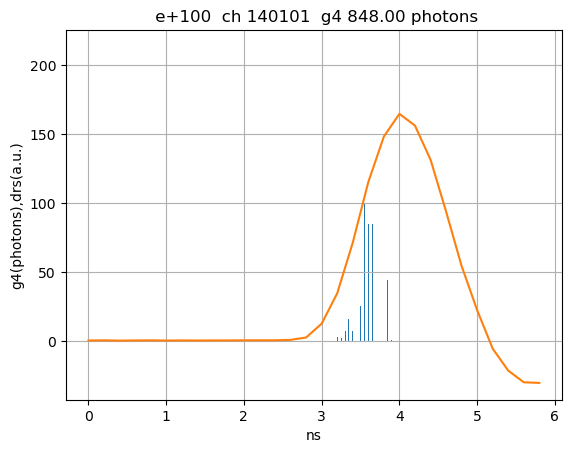

(def plotPulseTrain_v01) ch 140094


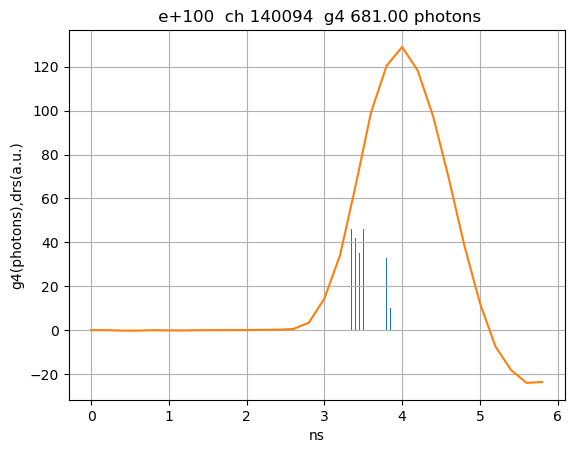

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  951.0   v1  704.0
(def plotPulseTrain_v01) ch 140101


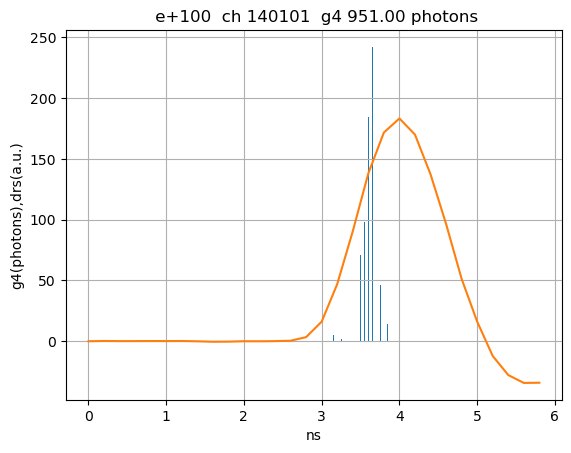

(def plotPulseTrain_v01) ch 140102


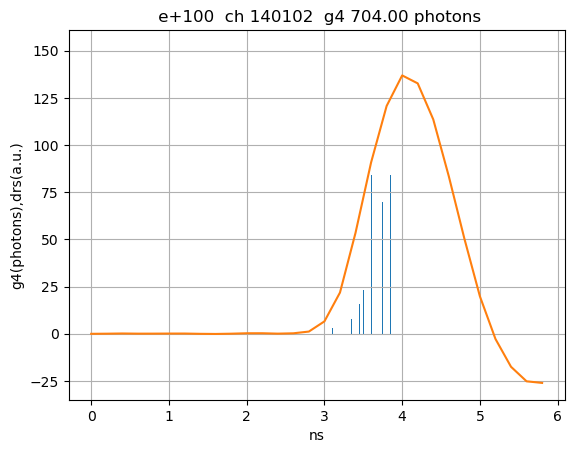

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  1044.0   v1  635.0
(def plotPulseTrain_v01) ch 140103


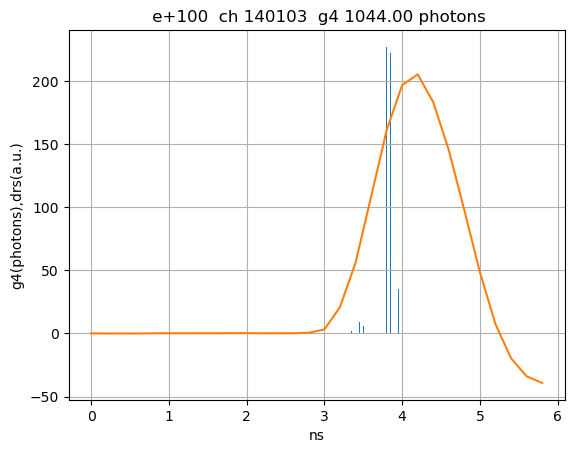

(def plotPulseTrain_v01) ch 140102


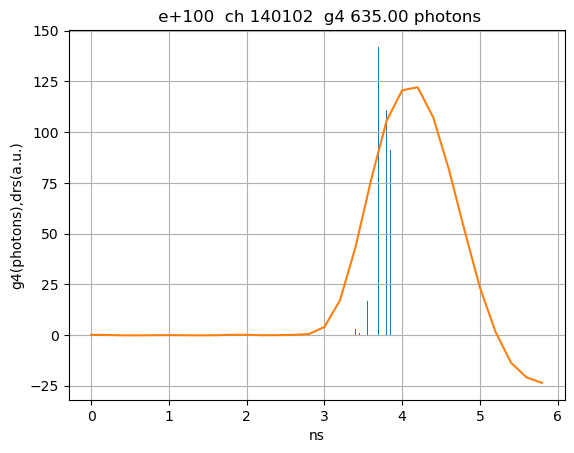

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  1077.0   v1  547.0
(def plotPulseTrain_v01) ch 140103


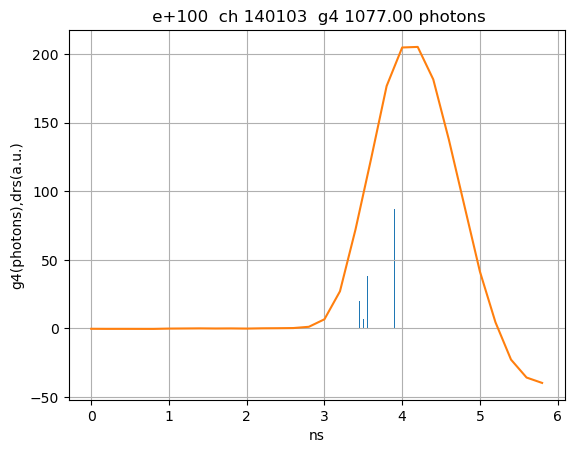

(def plotPulseTrain_v01) ch 140102


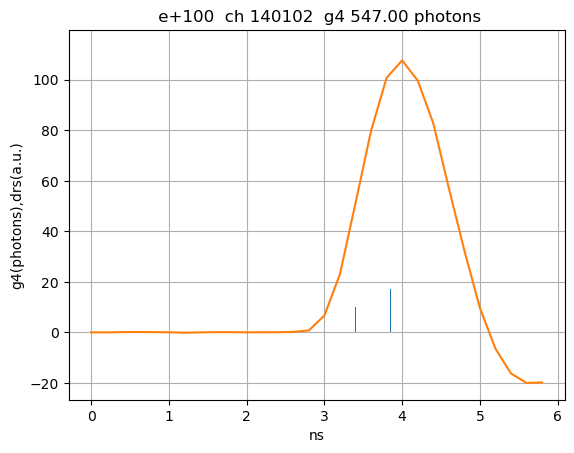

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  661.0   v1  521.0
(def plotPulseTrain_v01) ch 150102


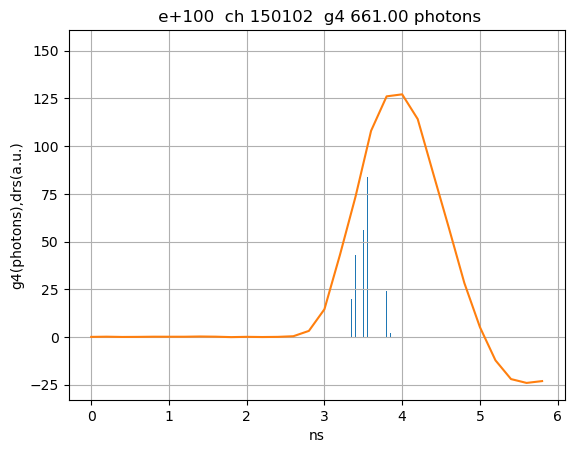

(def plotPulseTrain_v01) ch 140103


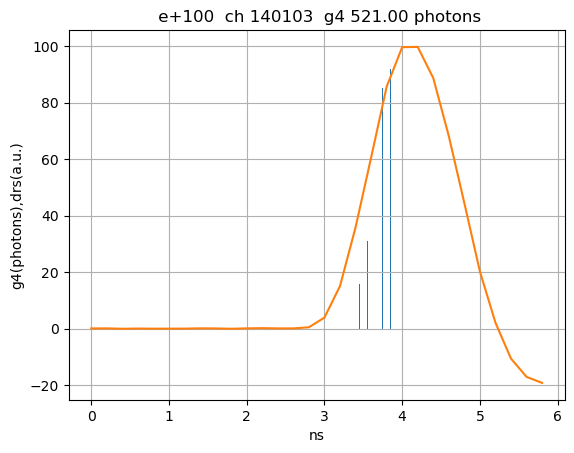

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  775.0   v1  748.0
(def plotPulseTrain_v01) ch 140103


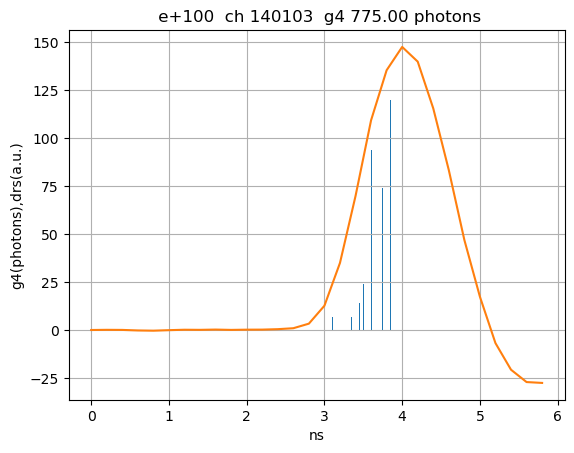

(def plotPulseTrain_v01) ch 140102


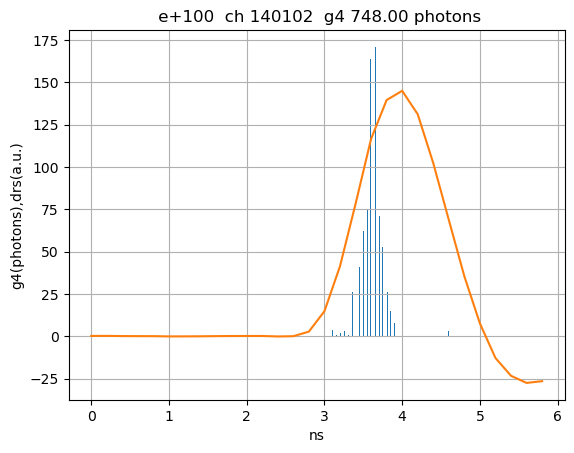

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  829.0   v1  510.0
(def plotPulseTrain_v01) ch 140103


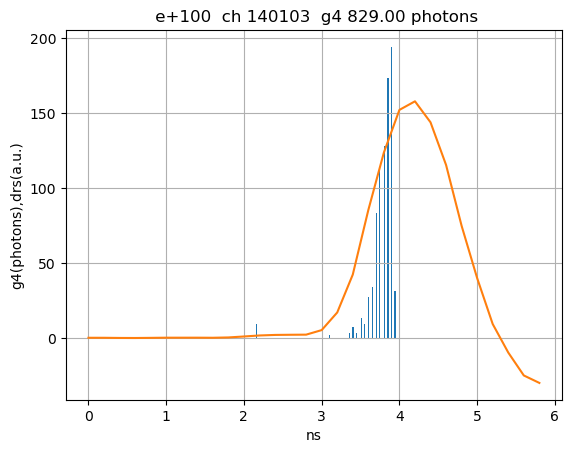

(def plotPulseTrain_v01) ch 150102


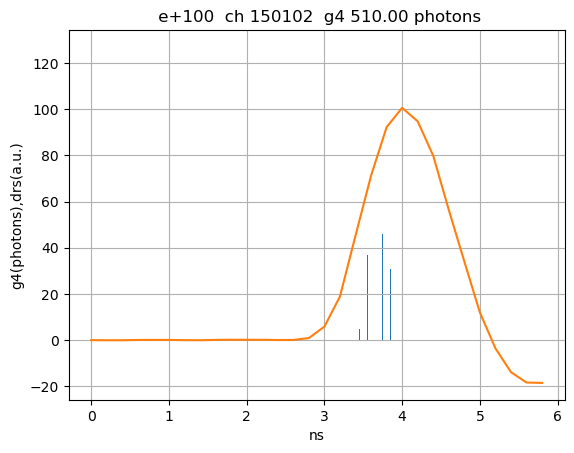

(def processDataset) df.keys(): dict_keys(['event', 'g4hit3dCC', 'g4hit3dSS', 'g4hit2dCC', 'g4hit2dSS', 'drsCC'])
v0  710.0   v1  465.0
(def plotPulseTrain_v01) ch 150094


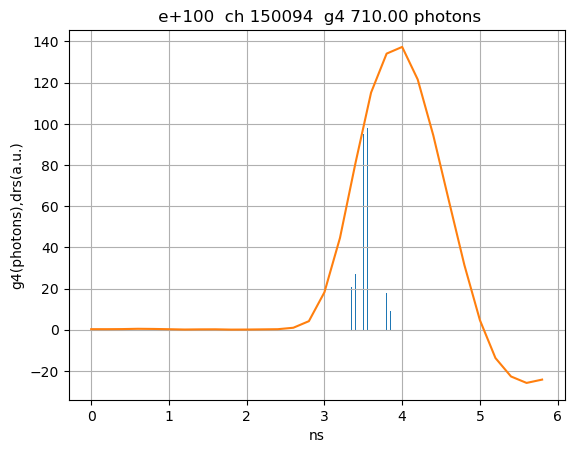

(def plotPulseTrain_v01) ch 140101


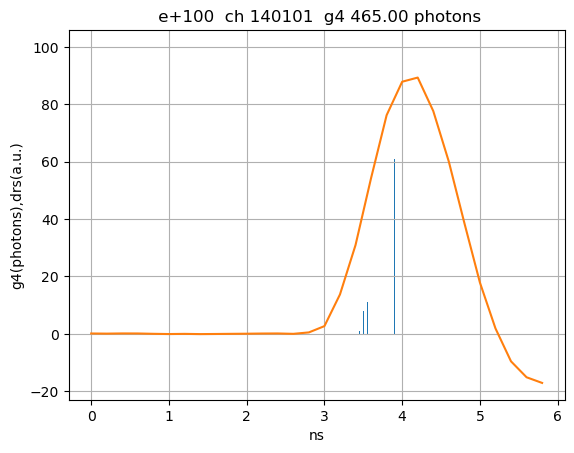

In [5]:
# main program 
nt=ntupleList()
trees=nt.getTrees()
datasets=nt.getKeys()
#
for ix, dataset in enumerate(datasets):
    print("start processing key number ",ix,"/",len(dataset),"  ",dataset)
    if ix==10:
        continue
    processDataset(dataset,trees)